## Метрики качества в задачах классификации. Продолжение

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import \
        fbeta_score, roc_auc_score, roc_curve, \
        precision_recall_curve, auc, average_precision_score

sns.set(style='dark', font_scale=1.7)

Для дальнейшего изучения метрик качества возьмем известный вам датасет blobs из sklearn и обучим логистическую регрессию:

In [0]:
X, y = make_blobs(n_samples=(500, 50), centers=[[2, 2], [-2, -2]], 
                  cluster_std=2.5, random_state=42)

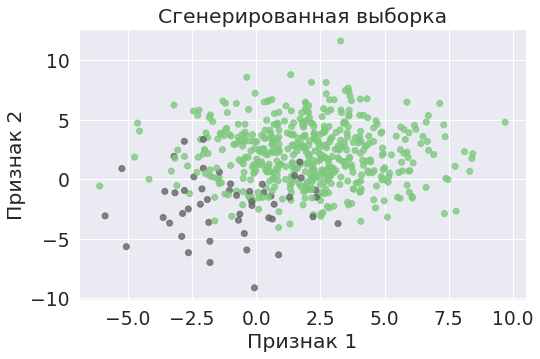

In [0]:
plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [0]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Обобщенная F-мера ($F_{\beta}$-мера)
[$F_{\beta}$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score)

Обобщением $F_1$-меры является $F_{\beta}$-мера, которая равна взвешенному гармоническому `precision` и `recall` с коэффициентом $\beta$:

$$F_{\beta} = (1 + \beta^2)\frac{ precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$

В данном случае $\beta$ определяет вес точности в метрике.

Эта метрика хороша в тех задачах, где от нас требуется обращать больше внимания на один из параметров `precision` или `recall`.

$0 < \beta < 1 \Rightarrow $ важнее `recall`

$\beta = 1 \Rightarrow $ получаем среднее гармоническое, то есть $F_1$-меру

$1 < \beta < +\infty \Rightarrow $ важнее `precision`

Одним из примеров задач, в которых полезно вычислять именно $F_{\beta}$ с $\beta \ne 1$, является задача предсказания болезни. 
В такой задаче гораздо важнее `recall`, нежели `precision`: лучше здоровому человеку сказать, что он болен и проверить его более тщательно, чем не определить больного.

Посчитаем $F_\beta$ -score для нашей задачи:

In [0]:
fbeta_score(y_test, clf.predict(X_test), beta=2)

0.5232558139534884

### Площадь под ROC-кривой (Area Under ROC Curve, AUC-ROC)

[AUC-ROC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc)
 
При переводе вещественнозначного ответа модели (например, в логистической регрессии, вероятности принадлежности к классу 1) в бинарную метку {$0$, $1$}, мы должны выбрать порог перехода. Обычно, таким порогом является $0.5$, но такой выбор не всегда является оптимальным, например, при отсутствии балансов классов.

Ранее изученные метрики (`precision`, `recall`, `accuracy`) характеризуют точность работы модели при конкретно выбранном пороге $t$ бинарной классификации.

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является `AUC-ROC`. Данная кривая представляет из себя кривую от (0,0) до (1,1) в координатах `True Positive Rate (TPR)` и `False Positive Rate (FPR)`.

Для понимания того, что такое `TPR` и `FPR` вспомним матрицу ошибок:

<center><img src="https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg" alt="drawing" width="400"/></center>

В приведенной ниже терминологии мы считаем класс с меткой 1 положительным, а с меткой 0 -- негативным

**TPR (True Positive Rate, полнота)** показывает какую долю объектов положительного класса модель классифицировала правильно:

$$TPR = \dfrac{TP}{TP + FN}$$


**FPR (False Positive Rate)** показывает, какую долю из объектов негативного класса модель предсказала неверно:

$$FPR = \dfrac{FP}{FP + TN}$$


Каждая точка на графике соответствует выбору некоторого порога бинарной классификации $t$. Площадь под кривой в данном случае показывает качество модели: чем она больше, тем классификатор лучше.

Также важным является крутизна самой кривой — мы хотим максимизировать `TPR`, минимизируя `FPR`, а значит, наша кривая в идеале должна стремиться к точке (0,1).

В идеальном случае, когда классификатор не делает ошибок ($FPR = 0$, $TPR = 1$) мы получим площадь под кривой, равную единице:

<center><img src="https://glassboxmedicine.files.wordpress.com/2019/02/roc-curve-v2.png" alt="drawing" width="400"/></center>


Заметим также, что `FPR` и `TPR` нормируются на размеры классов, поэтому `AUC-ROC` не поменяется при изменении баланса классов.

Посчитаем `ROC-AUC` для нашей задачи:

In [0]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.9576719576719577

Отрисуем `ROC-кривую`:

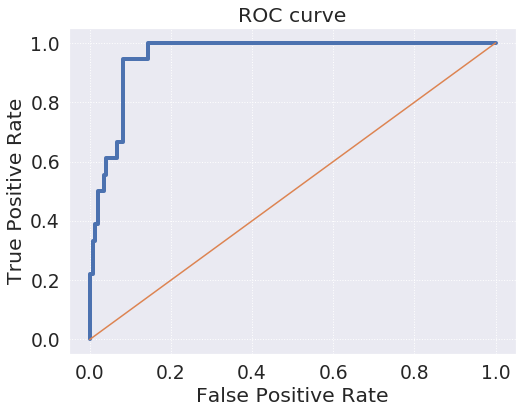

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=4, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(ls=":")
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Пример:**

Рассмотрим задачу предсказания реакции клиента банка на звонок с предложением кредита. Пусть в действительности (в нашей обучающей выборке) 10 клиентов из 100000 приняли предложение о кредите после звонка.

Рассмотрим 2 классификатора:

1. Предсказывает положительную реакцию для 20 клиентов из которых 9 релевантны. Для такой модели:

$$TPR = \dfrac{9}{9 + 1} = 0.9$$

$$FPR = \dfrac{11}{11 + 99979} = 0,0001$$

2. Предсказывает положительную реакцию для для 1000 клиентов из которых 9 релевантны. Для модели:

$$TPR = \dfrac{9}{9 + 1} = 0.9$$

$$FPR = \dfrac{991}{991 + 99499} = 0,001$$

Видно, что первая и вторая модель имеют одинаковые `TPR`. По разнице `FPR` двух классификаторов мы можем говорить о том, что в данной задаче стоит выбрать модель 1, но все-таки эта разница крайне мала. Дело все в том, что при подсчете `AUC-ROC` мы измеряем `FPR` относительно `TN`, что в задачах с несбалансированными классами (или в задачах, где бОльший класс нам не так важен) может давать не совсем релевантную картину при сравнении классификаторов.

Посчитаем `precision` и `recall` в данной задаче:

Первая модель:

$$precision = \frac{TP}{TP + FP} = \dfrac{9}{9 + 11} = 0.45$$

$$recall = \frac{TP}{TP + FN} = \dfrac{9}{9 + 1} = 0.9$$

Вторая модель:

$$precision = \frac{TP}{TP + FP} = \dfrac{9}{9 + 991} = 0.009$$

$$recall = \frac{TP}{TP + FN} = \dfrac{9}{9 + 1} = 0.9$$

Здесь же уже видна заметная разница в точности между двумя классификаторами :)

### Площадь под PR-кривой (Area Under PR Curve, AUC-PR)

[AUC-PR](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)

Аналогично `ROC-кривой`, определим `PR-кривую` как кривую в координатах `recall`  и `precision`, начинающуюся в точке (0, 1)

Каждая точка на графике соответствует выбору некоторого порога бинарной классификации  𝑡 . Площадь под кривой в данном случае показывает качество модели: чем она больше, тем классификатор лучше.

Также важным является "пологость" самой кривой — мы хотим максимизировать и `precision` и `recall`, а значит, наша кривая в идеале должна стремиться к точке (1,1).

В идеальном случае, когда классификатор не делает ошибок ( `precision=1`,  `recall=1` ) мы получим площадь под кривой, равную единице:

<center><img src="https://sun9-51.userapi.com/c205428/v205428042/83d48/4gmwjw9cuJU.jpg" alt="drawing" width="400"/></center>




Отрисум `AUC-PR` для нашей задачи:

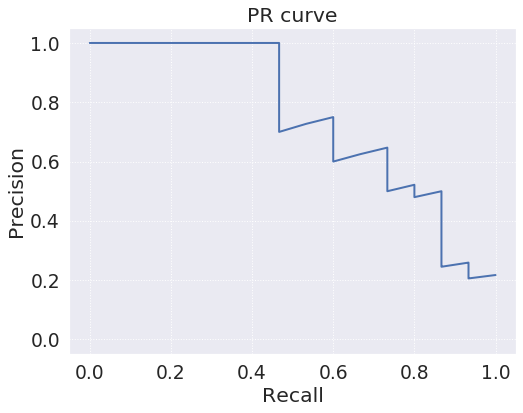

In [0]:
precisions, recalls, thresholds = precision_recall_curve(
    y_test, clf.predict_proba(X_test)[:,1]
)

plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, lw=2, label='PR curve')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(ls=":")
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

А также посчитаем площадь под данной PR-кривой, воспользовавшись функцией `auc`, которая считает площадь под кривыми с помощью метода трапеций:

In [0]:
auc(recalls, precisions)

0.7443719781308611

Или же используя формулу для `Average precision`:

$$AP = \sum\limits_n (R_n - R_{n - 1}) P_n, $$ где:

$P_n$ и $R_n$ -- `precision` и `recall` соответственно для $n$-ого порога классификации

In [0]:
average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7498480829896004

### Обобщение метрик классификации на многоклассовый случай. 

Как правило, это усреднение метрик для бинарной классификации. 

Бывает 2 вида усреднения: микро-усреднение и макро-усреднение.

1. **Микро-усреднение:** считаем характеристики (например: `TP`, `FP`, `TN`, `FN`) для бинарной классификации (один класс против всех) и усредняем их по всем классам. После этого считаем итоговую метрику по усредненным характеристикам. <br>
Например, точность будет вычисляться по формуле :
$$precision = \frac{\overline{TP}}{\overline{TP} + \overline{FP}},$$
где $\overline{TP} = \frac{1}{K} \sum\limits_{k = 1}^K TP_k$

2. **Макро-усреднение:** для каждого класса считаем итоговую метрику как для бинарной классификации (один класс против всех). После этого устредняем итоговую метрику по всем классам. <br>
Например, точность будет вычислена как 
$$precision = \frac{1}{K} \sum\limits_{k = 1}^K precision_k$$
где $precision_k = \frac{TP_k}{TR_k + FP_k}$

<br>

Заметим, что при микро-усреднении вклад каждого класса зависит от его размера. Действительно, размер класса сильно влияет на значения матрицы ошибок: `TP`, `FP`, `TN`, `FN`. <br>
При макро-усреднении такого эффекта не наблюдается: каждый класс вносит равный вклад в итоговую метрику, так как итоговая метрика уже не зависит от размера классов. <br>
Поэтому если модель плохо работает с маленькими классами, то метрика, полученная при макро-усреднении будет меньше, чем при микро-усреднении (ведь при макро-усреднении маленькие классы внесли такой же вклад, что и большие).


Посчитаем микро- и макро-усреднение для `f1-score` в задаче трехклассовой классификации

In [0]:
X, y = make_blobs(n_samples=(500, 250, 50), centers=[[2, 2], [-2, -2], [2, -2]], 
                  cluster_std=2.5, random_state=42)

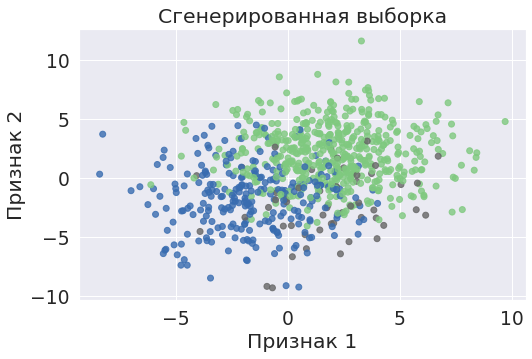

In [0]:
plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [0]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Микро-усреднение для f1-score

In [0]:
f1_score(y_test, clf.predict(X_test), average='micro')

0.8041666666666667

Макро-усреднение для f1-score

In [0]:
f1_score(y_test, clf.predict(X_test), average='macro')

0.6114245014245014

Полезные материалы:

[Связь между ROC-AUC и PR-AUC](http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf)

[Визуализация ROC-AUC](http://www.navan.name/roc/)